# 🌸 FLOWER PREDICTOR WITH SMART PADDING
(TRÌNH DỰ ĐOÁN LOÀI HOA SỬ DỤNG MOBILENETV2)

---
### 👤 AUTHOR INFO
* **Tác giả:** Bùi Tiến Phát
* **Email:** higo.individual@gmail.com
* **Project Type:** Nghiên cứu cá nhân / Thị giác máy tính
* **Kỹ thuật:** Transfer Learning, Smart Padding, I/O Optimization.

---
### 📝 MODULE HIGHLIGHTS (TÍNH NĂNG NỔI BẬT):
* **Auto-Load Model:** Tự động tải và sử dụng mô hình `.keras` từ Cloud (không cần cấu hình).
* **Smart Padding (Xử lý ảnh thông minh):** Sử dụng kỹ thuật Padding (thêm viền) để giữ nguyên tỷ lệ khung hình, giúp nhận diện chính xác cả ảnh dọc (9:16) và ảnh ngang (16:9) mà không bị méo.
* **1-Click Prediction:** Thao tác đơn giản, upload ảnh và nhận kết quả ngay lập tức.

**BƯỚC 1: KHỞI TẠO MÔI TRƯỜNG VÀ TẢI MÔ HÌNH**

**Mục tiêu:** Nạp thư viện cần thiết và tự động tải mô hình đã huấn luyện vào bộ nhớ.

In [ ]:
# 1: KHAI BÁO CÁC THƯ VIỆN
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gdown  # Thư viện tải file từ Drive công khai
from google.colab import files # Thư viện để upload ảnh input

print(f"--> TensorFlow version: {tf.__version__}")

--> TensorFlow version: 2.19.0


In [ ]:
# 2: CẤU HÌNH TẢI MÔ HÌNH TỰ ĐỘNG
MODEL_FILE_ID = '1JHTsxpl6cahPX8Ze337H7fUxJ0_c7nYV'
MODEL_NAME = 'flower_classifier_mobilenetv2_final.keras'
MODEL_PATH = f"/content/{MODEL_NAME}"

# 3: KIỂM TRA VÀ TẢI MÔ HÌNH
if os.path.exists(MODEL_PATH):
    print(f"✅ Phát hiện file mô hình '{MODEL_NAME}' đã có sẵn.")
else:
    print(f"--> Đang tải mô hình từ Server (ID: {MODEL_FILE_ID})...")
    url = f'https://drive.google.com/uc?id={MODEL_FILE_ID}'
    gdown.download(url, MODEL_PATH, quiet=False)

# 4: NẠP MÔ HÌNH VÀO BỘ NHỚ
print(f"--> Đang nạp mô hình...")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    print("✅ Nạp mô hình thành công! Hệ thống sẵn sàng dự đoán.")
except OSError:
    print("❌ LỖI: File mô hình bị lỗi hoặc không tồn tại. Vui lòng kiểm tra lại ID!")

# 5: ĐỊNH NGHĨA DANH SÁCH NHÃN (Labels)
class_names = ['black_eyed_susan', 'calendula', 'california_poppy', 'common_daisy', 'coreopsis', 'sunflower']
print(f"--> Danh sách các loài hoa hỗ trợ: {class_names}")

--> Đang tải mô hình từ Server (ID: 1JHTsxpl6cahPX8Ze337H7fUxJ0_c7nYV)...


Downloading...
From: https://drive.google.com/uc?id=1JHTsxpl6cahPX8Ze337H7fUxJ0_c7nYV
To: /content/flower_classifier_mobilenetv2_final.keras
100%|██████████| 9.72M/9.72M [00:00<00:00, 14.5MB/s]


--> Đang nạp mô hình...
✅ Nạp mô hình thành công! Hệ thống sẵn sàng dự đoán.
--> Danh sách các loài hoa hỗ trợ: ['black_eyed_susan', 'calendula', 'california_poppy', 'common_daisy', 'coreopsis', 'sunflower']


**BƯỚC 2: ĐỊNH NGHĨA HÀM DỰ ĐOÁN "SMART PADDING"**

**Kỹ thuật:** Sử dụng Padding (thêm viền đen) thay vì Resize trực tiếp để giữ nguyên tỷ lệ khung hình (Aspect Ratio), tránh làm biến dạng đối tượng, giúp mô hình nhận diện chính xác hơn trên ảnh thực tế.

In [ ]:
# 6: XÂY DỰNG HÀM XỬ LÝ ẢNH VÀ DỰ ĐOÁN (SMART PREDICTION)
def predict_flower_smart(image_path, model, class_names, target_size=224):
    """
    Hàm xử lý ảnh đầu vào (giữ nguyên tỷ lệ) và thực hiện dự đoán.
    Args:
      image_path: Đường dẫn đến file ảnh.
      model: Mô hình đã tải.
      class_names: Danh sách tên các loài hoa.
      target_size: Kích thước đầu vào của mô hình (mặc định 224x224).
    """

    # 6.1. Đọc và Kiểm tra ảnh
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Lỗi: Không thể đọc file ảnh tại {image_path}")
        return

    # Chuyển đổi không gian màu BGR (OpenCV) -> RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 6.2. Xử lý ảnh: Resize thông minh (Smart Padding)
    old_size = img_rgb.shape[:2] # (height, width)
    ratio = float(target_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize ảnh về kích thước mới (vẫn giữ tỷ lệ)
    img_resized = cv2.resize(img_rgb, (new_size[1], new_size[0]))

    # Tính toán phần viền đen cần thêm vào
    delta_w = target_size - new_size[1]
    delta_h = target_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Thêm viền (Padding) để tạo thành ảnh vuông hoàn hảo
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # 6.3. Hiển thị ảnh đầu vào
    plt.figure(figsize=(5, 5))
    plt.imshow(img_padded)
    plt.title("Ảnh đầu vào (Đã xử lý Padding)", fontsize=10)
    plt.axis("off")
    plt.show()

    # 6.4. Thực hiện dự đoán
    # Thêm chiều batch: (224, 224, 3) -> (1, 224, 224, 3)
    img_batch = np.expand_dims(img_padded, axis=0)

    # --- ĐÃ BỎ DÒNG PREPROCESS CỦA TÔI, DÙNG INPUT GỐC CỦA BẠN ---
    predictions = model.predict(img_batch)

    # 6.5. Giải mã và In kết quả
    pred_idx = np.argmax(predictions[0])
    pred_label = class_names[pred_idx]
    confidence = np.max(predictions[0]) * 100

    print("\n" + "="*25)
    print(f"🌸 KẾT QUẢ DỰ ĐOÁN 🌸")
    print("="*25)
    print(f"▶ Loài hoa:   {pred_label.upper()}")
    print(f"▶ Độ tin cậy: {confidence:.2f}%")
    print("="*25 + "\n")

**BƯỚC 3: THỰC HIỆN DỰ ĐOÁN (EXECUTE PREDICTION)**

**Hướng dẫn:** Chạy ô code bên dưới và chọn nút **"Choose Files"** để tải ảnh hoa từ máy tính lên. Hệ thống sẽ tự động xử lý Smart Padding và trả về kết quả.

--> Hãy chọn một file ảnh hoa từ máy tính ...


Saving black_eyed_susan (test1).jpg to black_eyed_susan (test1) (1).jpg

--> Đang xử lý file: black_eyed_susan (test1) (1).jpg


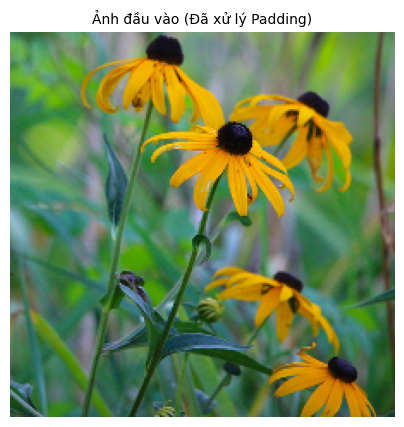

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

🌸 KẾT QUẢ DỰ ĐOÁN 🌸
▶ Loài hoa:   BLACK_EYED_SUSAN
▶ Độ tin cậy: 99.83%



In [ ]:
# 7: TẢI ẢNH VÀ CHẠY DỰ ĐOÁN
print("--> Hãy chọn một file ảnh hoa từ máy tính ...")
uploaded = files.upload()

for fn in uploaded.keys():
    print(f"\n--> Đang xử lý file: {fn}")
    # Gọi hàm dự đoán đã định nghĩa ở Bước 2
    predict_flower_smart(fn, model, class_names)